# Basics of Mobile Robotics



## Table of Contents

* [Introduction](#chapter1)
    * [Framework](#section_1_1)
    * [Environment](#section_1_2)
    * [Modules](#section_1_3)
    * [Librairies](#section_1_4)

* [Computer Vision](#chapter2)
    * [Vision : initialization and calibration](#section_2_1)
    * [Vision : features detection](#Section_2_2)
        * [Obstacles Detection](#section_2_2_1)
        * [Goal Detection](#section_2_2_2)
        * [Thymio Detection](#section_2_2_3)
    * [Global Map](#Section_2_3)
    * [Resize](#Section_2_4)
* [Global Navigation](#chapter3)
    * [Path Planning](#section_3_1)
    * [Motion Planning](#section_3_2)
    
* [Kalman Filter](#chapter4)
    * [Prediction](#section_4_1)
    * [Update](#section_4_2)
   
* [Local Navigation](#chapter5)
    * [Local Avoidance](#section_5_1)
    * [Kidnapping](#section_5_2)
    
* [Overall Project](#chapter6)
    * [Overview](#section_6_1)
    
* [Conclusion](#chapter7)
* [Sources](#chapter8)

## 1. Introduction <a class="anchor" id="chapter1"></a>



### 1.1 Framework  <a class="anchor" id="section_1_1"></a>
First of all, we decided to make a framwork prior to start coding. We thought it would help us to manage better the project with the big picture, to have a better understanding of what needs to be done and take as early as possible decisions about the structure. For filtering we decided to use a Kalman filter who would filter the robot position and angle detected from vision. To improve it, whe decided to add the odometry of the motors to its input. At this stage, we had in mind to compensate for vision defect with odometry, which ends up being very succesful. Then, we decided to make a grid base map. We thought it would be easy and convinient since the images from the camera are already in a grid based fashion with the pixels. It led us to use the A* algortihm for the path planning, which is easy to use, with good and accesible off-the-self ressources. The rest of the framework was then straightforward. 

![frame](image/framework.jpg)


### 1.2 Environment <a class="anchor" id="section_1_2"></a>
Here is an image of our environment. We mounted the camera on the ceiling to make sure it was very stable and to have similar lighting conditions and a constant distance between the map and the camera.

![frame](image/env.jpg)

### 1.3 Modules <a class="anchor" id="section_1_3"></a>

We tried as much as possible to keep our code as simple as possible and therefore we made it very modular. We tried to seperate features that are independant and therefore we made a intensive use of classes and independant files.

Here is a summary :
* GlobalMapClass
* VisionClass
* KalmanFilterClass
* LocalNavigatorClass
* calibrate
* ShorthestPath
* motionPlanning


The central element of the project is of course our global map. It is it that make every other part work together. We made it as a class so a globalMap element can store data, the type and format is always clearly define. We manipulate them with setter and getter function to always keep it clean and sync. 

Then, of course, in order to have a global map we need some input from the camera. We need computer vision. We made a vision class because it was convinient to have an element that manage an instance of the camera, that stores  the last image and filter values. This allows also to make clear high levels functions.

To improve the results of the computer vision we decided to use a Kalman Filter. We made it a class because once again, having high levels functions without the need of dealing with specific data in the main file (like kalman uncertainty matrix, etc.) was convinient.

Finally, our last class is the local navigation class. It manages the thymio robot, and make it work asyncronously with our main file. It keeps track of speed, direction, last detected obstacles, etc. It also convinient to keep only the high levels functions in the main.

Then we add use for other separate files for specific task/functions. The calibrate library comes first. It open an instance of the camera in order to calibrate the values of the vision's filters. It makes our project less setup dependant.

Then we have the ShorthestPath library, wich simply take care of the A* implementation.

Finally, the motion planning file. It's were we decides how the thymio should follow the path.


We hoped this modular structure would help us write code that is more readable and that it will spare us mistakes.

### 1.4 Librairies <a class="anchor" id="section_1_4"></a>
We used also some standard library

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
from tdmclient import ClientAsync, aw
from matplotlib import colors
import math

## 2. Computer Vision <a class="anchor" id="chapter2"></a>

The computer vision is an essential part of the project, it allows us to know : where the robot is, where is the goal and finally where the obstacles lay. In order to make clean code we decided that the computer vision should be a class. So we can create an instance of that class that could open the camera, stores the values needed from call to call like the last taken image and keep the main code as clear and simple with only high levels functions that are :
* vision.initialize() : run the calibration if asked, open the camera
* vision.update() : take a new picture
* vision.robotDetection()
* vision.goalDetection()
* vision.obstaclesDetection(expand)


Here we will define an element of that class. Please mind that we don't call vision.initialize() because we won't open the camera. Therefore, we can't also call the vision.update(). Instead we will manualy load the images that are intersting here, in the scope of a report.

In [2]:
from VisionClass import VisionClass

vision=VisionClass(False)

### 2.1 Vision : initialization and calibration <a class="anchor" id="section_2_1"></a>

First, when we declare an element of visionClass, we pass a boolean that states if we will run or not a "hand" calibration. We usually do it everytime to have a robust vision.

We will detect the robot, goal by filtering a specific color out of an image with a cv2.inRange filter based on an image either in HSV format or in RGB format. For simplicity we will refer them as HSV filter and RGB filter thereafter. The cv2.inRange() function return a grid with positive values only for the corresponding pixels with value between the low and high range provided to the function.  The obstacles will be detected based on a cv2.treshhold filter. 

The Ligthing conditions may differ tremendously during the day or from one place to another. This was the motivation to make calibration easy, fast and intuitive for each attempt. In order to do so, we launch a program to manually and simply calibrate the value of the RGB or HSV filter for goal and robot detection as well as treshhold filter for obstacles detection.

When we launch the calibration function, it will open two display, the camera and the mask. The "camera" display obviously shows the camera images, and the mask shows the output of the chosen filter. 

One can chose between the following filter :
* RGB filter : by double clicking on the "camera" display, it will acitvate it and where the mouse was pointing when clicking is the RGB value of the filter.
* HSV filter : by scrolling the mouse roulette, it will activate this filter and modify the H value (approx. the color). One can modify S and V (approx. luminosity treshhold) value with the key O/L and P/M respectively.
* The Treshhold filter : by first doublecliking, then pressing Tor F key. The keys also modify the value of the filter.

When we're happy with the results of one filter, we can assign it to the goal detection by pressing the key G, or to the robot detection by pressing the key R. The treshhold value for obstacles detection is always the last treshhold selected. We can end the calibration by simply pressing the key Q and all the filter parameters will be passed to the vision part. If we don't assign a filter for goal or robot detection, defaults value will be passed.

In [4]:
import calibrate
print(calibrate.calibration())

(150, 70, 90, False, 90, 50, 50, True, 70)


Please mind that this function is setup dependant (because of the camera) and this may fail.
The value that are returned are the value selected for the goal filter, then a boolean if the filter is either RGB or HSV, then the same for the robot with filter value and a boolean for the filter type. Finally, the treshhold value is returned. 

### 2.2 Vision : features detection<a class="anchor" id="section_2_2"></a>

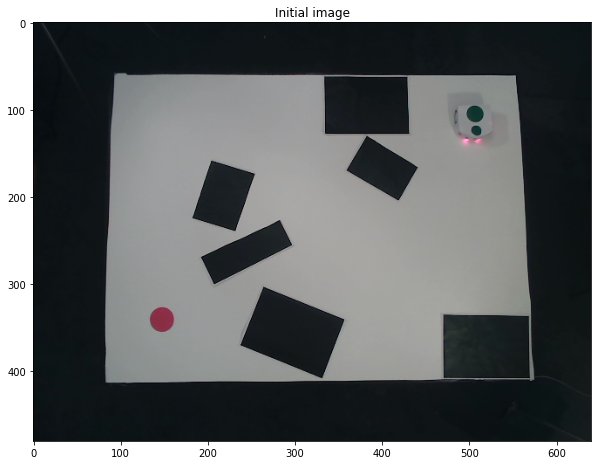

In [120]:
#read and plot image to analyse
image = cv2.imread('image/finalMap.png')
plt.subplots(figsize=(10,10))
plt.title("Initial image")
_=plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

We used the computer vision for:
* Robot detection
* Goal detection
* Obstacles detection

In order to detect this objects, we use the values manually calibrated previously for the HSV and the RGB filters as well as the threshold. 

#### 2.2.1 Robot detection

First we apply a blur filter on the image in order to smooth the image and ensure we do not detect unsignificant features in the image. 

Then, in order to detect the robot, we:
* Detect green (the colour of the robot), for that we have two possible filters : HSV or RGB, and we decide manually which one is better to use in this conditions if we do the handcalibration. Otherwise, we use the HSV filter to detect green because it is the one that fits the best most of the time.
Here we use the values founded manually when we took the picture.
* Detect circles : we must detect the two circles of the robot to know the position and set the direction of the robot.
In order to do that we find all the contours in the image using an openCV function and we select the contours big enough to correspond to the circles of the robot. (and to ensure we do not consider noise as a circle) 
* Finally, we compute the position and the direction of the robot thanks to the values found for the position of the two circles 

Robot position in pixel is: 510 118  and orientation in radian : 1.6233793884058383


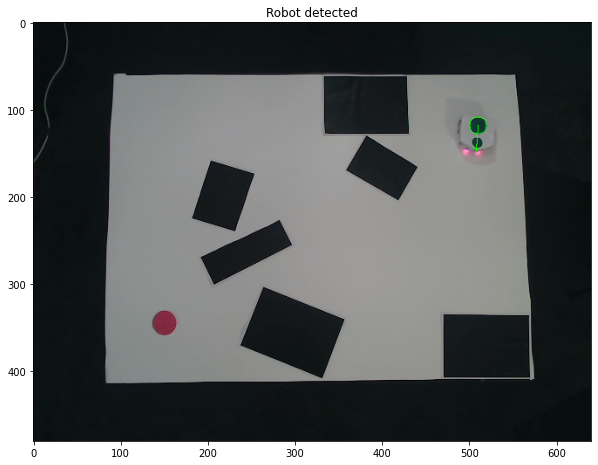

In [15]:
# manually seting the image and filter to work with instead of calling vision.initialize and vision.update
# that need a camera.
vision.lowRobot = np.array([30, 50, 50])
vision.highRobot = np.array([100, 255, 255])
vision.HSVR = True
vision.image = image.copy()
vision.imageDraw = image.copy()


[robotPosX, robotPosY, theta] = vision.robotDetection()


#Display
print("Robot position in pixel is:", robotPosX, robotPosY," and orientation in radian :", theta)
plt.subplots(figsize=(10,10))
plt.title("Robot detected")
_=plt.imshow(cv2.cvtColor(vision.imageDraw, cv2.COLOR_BGR2RGB))

#### 2.2.2 Goal detection

Here we detect the goal using the same process as above for the robot. 

This time we only have two steps :
* Detect red color : for the goal, by default we use a RGB filter which is more appropriate for the detection of the red. 
* Detect the circle, using the same function as above for the robot.

Goal position is: 150 344


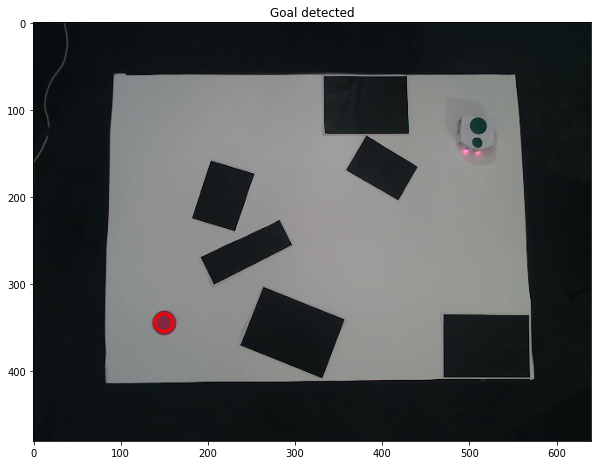

In [16]:
# manually seting the image and filter to work with instead of calling vision.initialize and vision.update
# that need a camera.
vision.lowGoal = np.array([37, 14, 90])
vision.highGoal = np.array([97, 74, 150])
vision.HSVG = False
vision.image = image.copy()
vision.imageDraw = image.copy()


[goalPosX, goalPosY] = vision.goalDetection()


#Display
print("Goal position is:", goalPosX, goalPosY)
plt.subplots(figsize=(10,10))
plt.title("Goal detected")
_=plt.imshow(cv2.cvtColor(vision.imageDraw, cv2.COLOR_BGR2RGB))

#### 2.2.3 Obstacle detection


To detect the obstacles, we need to apply some filters on the image taken by the camera in order to have a good image to analyse.
First we need to pay attention to have a RGB image (convert the BGR image to a RGB image), then we apply :
* A Blur filter : a blur filter to prevent from detecting unsignificant features of the image using edge detection.
* A Bilateral filter : a bilateral filter to preserve edges while smoothing the image.
* A threshold to convert the map into a binary map 

We then use morphological operators :
* Erode to remove noise.
* Dilate the image such as the robot never touches the obstacles.

Finally, we go through each pixel of the binary map : if the pixel is black then the pixel is occupied ( = 1) otherwise, it is considered as free ( = 0) and the robot can pass through the case. 
This gives us the occupancy grid that the A* star will use to find the shortest path.

Here is the code of the processing of the image.

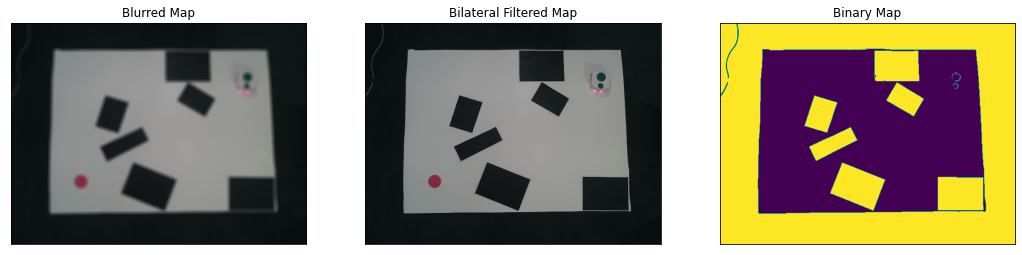

In [30]:
image_obstacles = image.copy()

# Convert to RGB
map_rgb = cv2.cvtColor(image_obstacles, cv2.COLOR_BGR2RGB)

# Blur Image
map_blur = cv2.blur(map_rgb,(10,10))

# Apply Bilateral filter
map_bilateral = cv2.bilateralFilter(map_rgb,5,15,15)

# Create Binary Image
map_gray = cv2.cvtColor(map_bilateral, cv2.COLOR_RGB2GRAY)
_, map_binary = cv2.threshold(map_gray, 40, 255, cv2.THRESH_BINARY_INV)

# Opening to remove noise
kernel_morph = np.ones((10,10),np.uint8)
map_clean = cv2.morphologyEx(map_binary, cv2.MORPH_OPEN, kernel_morph)

kernel_erode = np.ones((10,10),np.uint8) 
kernel_dilate = np.ones((70,70),np.uint8) 
map_occupancy = cv2.erode(map_clean, kernel_erode, iterations=1)
map_occupancy = cv2.dilate(map_occupancy, kernel_dilate, iterations=1)

plt.figure(figsize=(18,18))

plt.subplot(1,3,1),plt.imshow(map_blur)
plt.title("Blurred Map")
plt.xticks([]),plt.yticks([])

plt.subplot(1,3,2),plt.imshow(map_bilateral)
plt.title("Bilateral Filtered Map")
plt.xticks([]),plt.yticks([])

plt.subplot(1,3,3),plt.imshow(map_binary)
plt.title("Binary Map")
plt.xticks([]),plt.yticks([])
plt.show()

We can also just run the function "occupancy grid" which call the function detailed just above. Please mind that the results aren't exactly the same. This is because here, when calling Vision.obstaclesDetection, we can chose to expand or not the obstacles. The idea is to expand the obstacles of more than half thymio's width, so the optimized path won't come to close to the obstacles. Here we plot both, obsatcles in dark grey and expanded obstacles in light grey. 

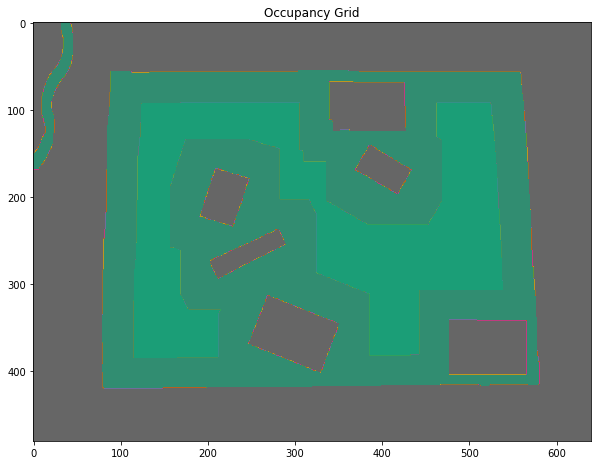

In [24]:
# manually seting the image and filter to work with instead of calling vision.initialize and vision.update
# that need a camera
vision.tresh = 40


obstaclesMap = vision.obstaclesDetection(False)
expendedObstaclesMap = vision.obstaclesDetection(True)


#plot the occupancy grid
fig, ax = plt.subplots(figsize=(10,10))
plt.title("Occupancy Grid")
ax = plt.gca()
ax.invert_yaxis()
ax.imshow(obstaclesMap, cmap=plt.cm.Dark2)
_=ax.imshow(expendedObstaclesMap, cmap=plt.cm.Dark2, alpha=0.3)

### 2.3 Global Map<a class="anchor" id="section_2_3"></a>

To sumarize, we start to calibrate our filters in order to detect correctly : the robot, the goal and the obstacles. Then, we saw the three function Vision.robotDetecion(), Vision.goalDetection() and vision.obstaclesDetection() to detect everything we need. We can now put these elements together to generate a map for the robot with the goal and the expanded obstacles.


We thought it would be convenient to somehow have always the most up-to-date map stored somewhere, that would stay sync, easy to use and with data always in the format we want it to. This was our motivation to create the class GlobalMapClass. It simply stores the robot, goal and obstacles. Also, we don't want to update these three elements at the same frequency, therefore having a object of globalMapClass makes our code more readable, easy to understand and it saved us time of troubleshouting errors, since we had early define the format and type of data we were going to work with.

Here, we will initialize the global map exactly the way we do it in the code, so we can use it afterwards.

Global Map initialize correctly


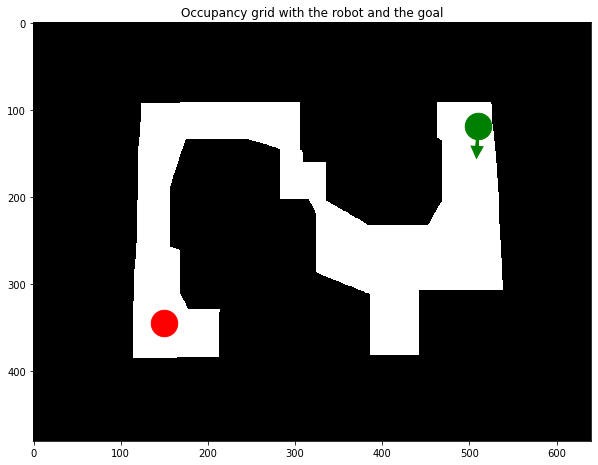

In [40]:
from GlobalMapClass import GlobalMapClass

globalMap=GlobalMapClass()

vision.image = image.copy()
flag=True

flag&=globalMap.setRobot(vision.robotDetection())
flag&=globalMap.setGoal(vision.goalDetection())
globalMap.setObstacles(vision.obstaclesDetection(True))

if(flag):
    print("Global Map initialize correctly")
    plt.figure(figsize=(10,10))
    plt.title("Occupancy grid with the robot and the goal")
    cmap = colors.ListedColormap(['white', 'black'])
    plt.imshow(globalMap.getObstacles(), cmap=cmap)
    plt.scatter(globalMap.getGoal()[0], globalMap.getGoal()[1], marker="o", color='red', s=700);
    plt.scatter(globalMap.getRobot()[0], globalMap.getRobot()[1], marker="o", color='green', s=700);
    plt.arrow(globalMap.getRobot()[0], globalMap.getRobot()[1], 25*math.cos(globalMap.getRobot()[2]),
              25*math.sin(globalMap.getRobot()[2]), head_width=10, head_length=10, fc='green', ec='green', lw=3)
else:
    print("Global Map initialization error : try to re-run everything rom the beginning in the right order")
    

### 2.4 Resize<a class="anchor" id="section_2_4"></a>

At some point, we decided to add a function resize/rescale that map an image where the distances are expressed in pixel to a map where the distances are expressed in centimeters. This would allow the program to work regardless the distance between the camera and the map. The principle was to detect the largest rectangle in the image, which conserpond to the countours of our map, whose size we know in centimeters. We were then able to calcultate ratios for mapping pixels to centimeters.

Even though that would have been a great feature and we had already made good working code, we decided not to use it. We had some non neglectable rounding errors, and it wasn't yet robust enough. Instead we decided to fix the camera at the ceiling an always keep a constant height. Indeed, it was more robust, the resolution of the map, precision and accuracy was higher.

We provide here the code just for curiosity. It's not used in our code anymore.


In [ ]:
#Code used for the resize part 
def Size(self):
    #filter
    gray=cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
    self.map=gray
    blur=cv2.GaussianBlur(gray, (3, 3), 0.5)
    self.mask=blur
    edge=cv2.Canny(blur, 0, 50, 3)
    self.erode=edge

    #find Countours
    contours, hierarchy=cv2.findContours(edge, cv2.RETR_EXTERNAL,
                                           cv2.CHAIN_APPROX_SIMPLE)
    #if no contours are found
    if(len(contours) < 1):
        return False

    #take largest rectangle
    x,y,w,h = 0,0,0,0
    for cnt in contours:
        x_new,y_new,w_new,h_new=cv2.boundingRect(cnt)
        if(w_new*h_new>w*h):
            x,y,w,h=x_new,y_new,w_new,h_new

    #dray rectangle for display purpose
    self.imageDraw=self.image.copy()
    cv2.rectangle(self.imageDraw, (x,y), pt2=(x+w,y+h), color=(255,0,0), thickness=10)

    #set up variables for grid conversion
    self.cornerX=x
    self.cornerY=y
    self.ratioX=w
    self.ratioY=h
    return True

## 3. Global Navigation <a class="anchor" id="chapter3"></a>

Global navigation based itself on the globalMap we defined and declared above. Please run carefully all the previous cell in the right order in you intend to run the global navigation cells.

Global Navigation is the part that plan a path for the robot and then decide how he should folow it in functions of its actual state (position and orientation) by giving the input to the local navigation. 

### 3.1 Path Planning <a class="anchor" id="section_3_1"></a>

We need now to make a path the robot can follow in order to reach the goal. Since we have a map in a grid fashion, we decided to use the A* algorithm. It's efficient, easy to understand and has well documented off-the-self ressources. This wasn't a strong debate among us to decide which algorithm to use because previous choices we made (kalman filter, grid base map), made A* a natural choice.  

By now, we have the robot and goal position as well as an obstacle grid. Everything is expressed in the pixel unit. It makes grid of consequent size but the A* implementaion we use (see sources) manage to solve it in approximativly 10 seconds, which was acceptable for us. As discussed prior, we thought at some point to make a smaller grid in centimeters instead of pixel, in order to make the A* run faster, but this was abandonned in particular because the path planning was running fast enough for our criteria. 

The A* ouput an optimize path in the sense of an grid based path. This isn't true anymore when we quit the grid based representaion as for example in the real world with our thymio. Howerver, we used 8N movements in our grid instead of 4N to make the trajectory a bit smoother and the outputed path seems resonable enough for us.

Finally, here, we can understand better why we needed to expand the obstacles. The performance and hence the optimization always lies at the constraints, and the optimized path simply comes to close to the obstacles for the thymio not to run over them. Expandind the obstacles in therefore a trade-off between performance (shorter path are closer to the wall) and safety.

we won't get into the details of the A* implemention but please mind that it take advantages of the heapq library, that manages sorted list in a way, for the open set in particular,

A* ran in  10.320826053619385 seconds


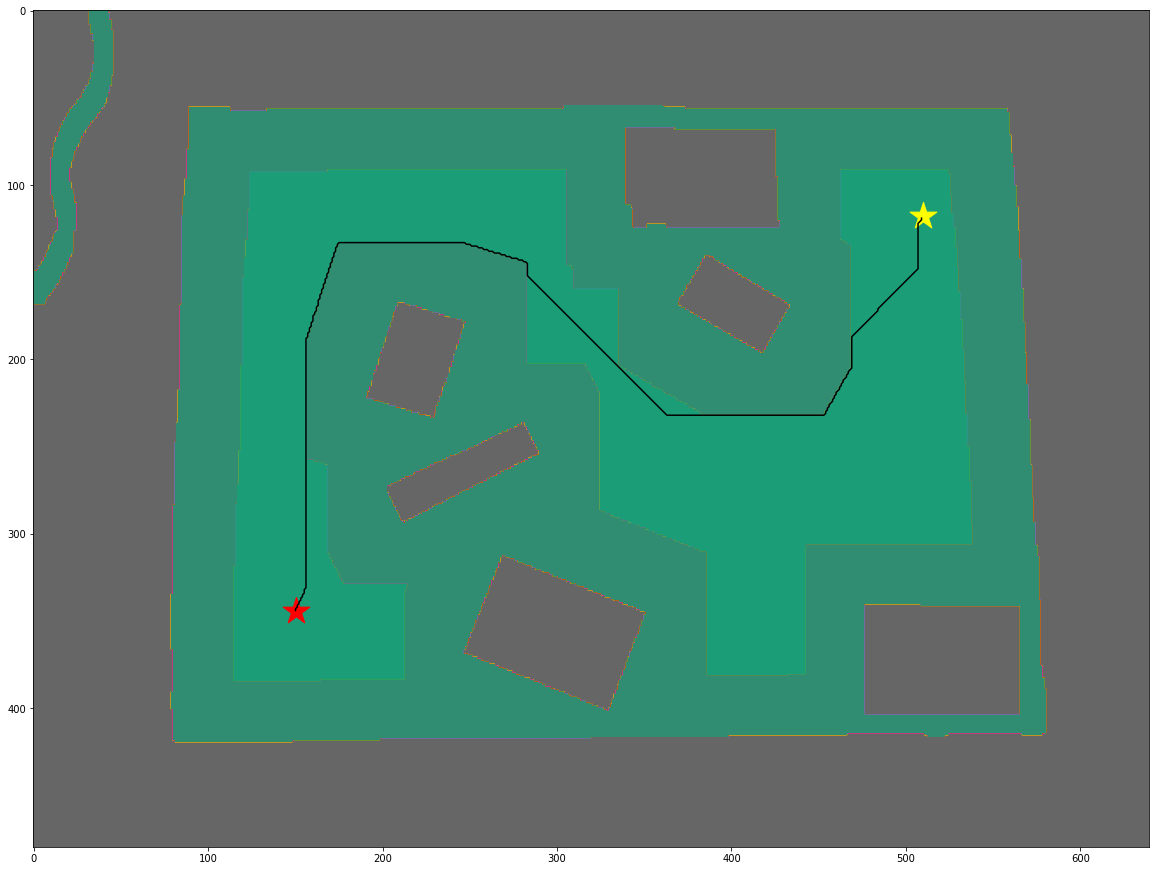

In [102]:
import ShorthestPath as sp

start=time.time()
route=sp.astar(globalMap.getObstacles(),globalMap.getMapSize()[0], globalMap.getMapSize()[1],
                              globalMap.getRobot(), globalMap.getGoal())
stop=time.time()

# Display
print("A* ran in ", stop-start, "seconds")
x_coords = []
y_coords = []
for i in (range(0,len(route))):
    x = route[i][1]
    y = route[i][0]
    x_coords.append(x)
    y_coords.append(y)
fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(obstaclesMap, cmap=plt.cm.Dark2)
ax.imshow(globalMap.getObstacles(), cmap=plt.cm.Dark2, alpha=0.3)
ax.scatter(globalMap.getRobot()[0],globalMap.getRobot()[1], marker = "*", color = "yellow", s = 800)
ax.scatter(globalMap.getGoal()[0],globalMap.getGoal()[1], marker = "*", color = "red", s = 800)
ax.plot(y_coords,x_coords, color = "black")
plt.show()

### 3.2 Motion Planning<a class="anchor" id="section_3_2"></a>

The motion planning take care of giving the local navigation the direction it should follow. In a sense, it's like our smartphone GPS when we go from one place to another, we're not in particular intersted in where we are in the city, but mostly in where we should go in our environnement. This is exactly what the motion planning is doing. It looks at the big pictures (path and robot position) and output a direction the robot should follow. 

It based on two proportionnal controller, one for angle correction and the other for position correction. The combination of these two controllers gives us fairly good results because angle correction is a very effective way to follow a path, but it can't correct offset from that path. We could follow the path with the right trajectory but being five centimeters left to the path for the whole trajectory. This is why we added a position controller. It has poorer performance when it comes to follow a path but it can track this offset down to zero. A combination of the two is a simple yet effective and robust way to follow the path.

First we start by finding where we are on the path (the closest point), then for the angle controller we compute what should be the angle to reach the next point. For the postion controller, we compute the angle that brings us closer to the path. Then we add them together and adjust the weight of each of them until we're happy with the results. 

> 1. Find the point of which the robot is the closest
> 2. Find the angle between that point and the next one (or a few ahead to avoid 90 degrees turn) on the path
> 3. Compute proportionnal angle correction between that path angle and the robot orientation
> 4. Compute proportionnal distance to path correction, with the point on the path and the robot position. We find the sign of this correction by looking at if the correction brings the robot closer to the path or not. 
> 5. Sum up the two correction and adjust gain.

It return the desired angle correction. Which means how much of an angle we want to add to the actual robot's orientation. 

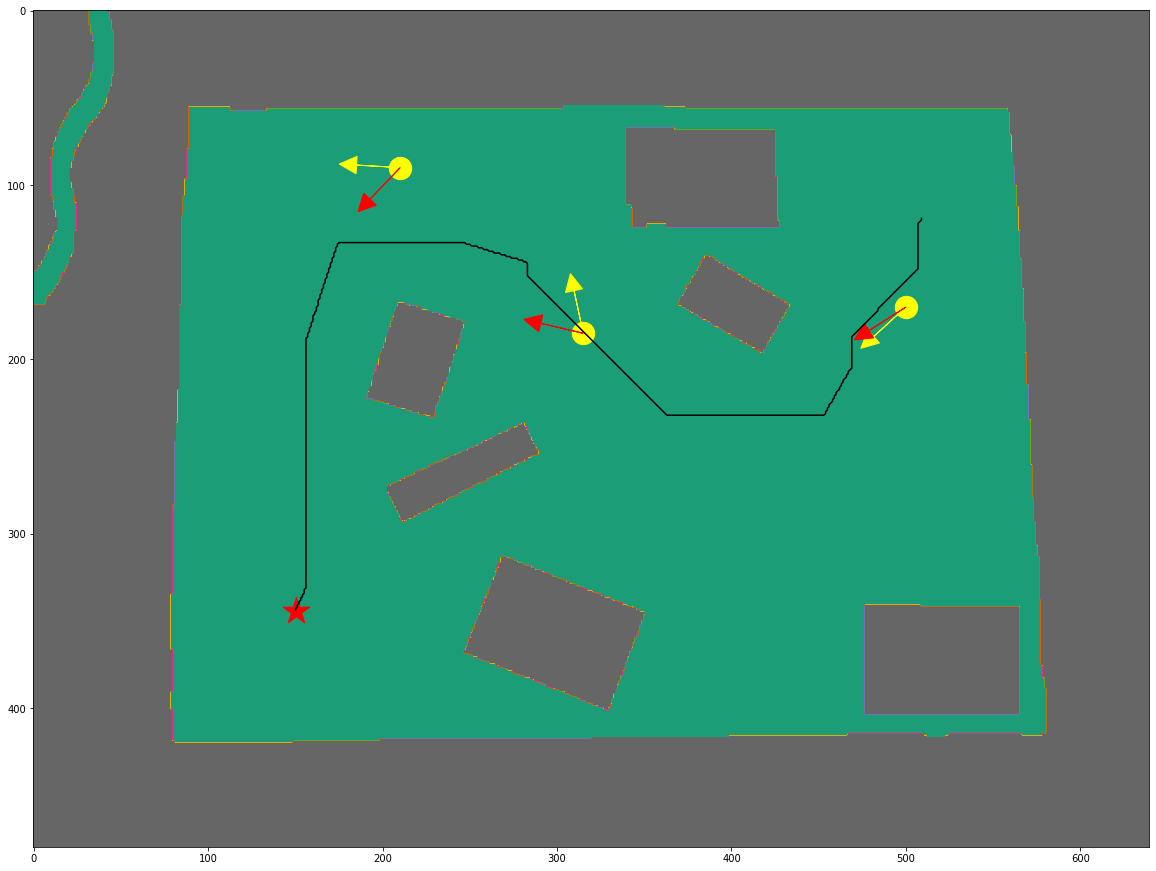

In [119]:
import motionPlanning

robot = [500, 170, 2.4] #(x,y,theta)
robot2 = [210,90, 3.2]
robot3 = [315,185,4.5]


desiredAngleCorrection = np.pi*(motionPlanning.getMotionAngle(route, robot))/180
desiredAngleCorrection2 = np.pi*(motionPlanning.getMotionAngle(route, robot2))/180
desiredAngleCorrection3 = np.pi*(motionPlanning.getMotionAngle(route, robot3))/180


# Display
fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(obstaclesMap, cmap=plt.cm.Dark2)
ax.plot(y_coords,x_coords, color = "black")
ax.scatter(globalMap.getGoal()[0],globalMap.getGoal()[1], marker = "*", color = "red", s = 800)
plt.scatter(robot[0], robot[1], marker="o", color='yellow', s=500);
plt.scatter(robot2[0], robot2[1], marker="o", color='yellow', s=500);
plt.scatter(robot3[0], robot3[1], marker="o", color='yellow', s=500);
plt.arrow(robot[0],robot[1], 25*math.cos(robot[2]),
              25*math.sin(robot[2]), head_width=10, head_length=10, fc='yellow', ec='yellow', lw=1)
plt.arrow(robot[0],robot[1], 25*math.cos(robot[2]+desiredAngleCorrection),
              25*math.sin(robot[2]+desiredAngleCorrection), head_width=10, head_length=10, fc='red', ec='red', lw=1)
plt.arrow(robot2[0],robot2[1], 25*math.cos(robot2[2]),
              25*math.sin(robot2[2]), head_width=10, head_length=10, fc='yellow', ec='yellow', lw=1)
plt.arrow(robot2[0],robot2[1], 25*math.cos(robot2[2]+desiredAngleCorrection2),
              25*math.sin(robot2[2]+desiredAngleCorrection2), head_width=10, head_length=10, fc='red', ec='red', lw=1)
plt.arrow(robot3[0],robot3[1], 25*math.cos(robot3[2]),
              25*math.sin(robot3[2]), head_width=10, head_length=10, fc='yellow', ec='yellow', lw=1)
_=plt.arrow(robot3[0],robot3[1], 25*math.cos(robot3[2]+desiredAngleCorrection3),
              25*math.sin(robot3[2]+desiredAngleCorrection3), head_width=10, head_length=10, fc='red', ec='red', lw=1)

We see here, the three distinctive cases.
1. The robot is exaclty on the path but with a wrong orientation, the correction try to align the robot with the path
2. The robot as the same orientation than the path but he is next to it. The correction try to bring the robot closer to the path.
3. A mix of the two

## 4. Kalman Filter <a class="anchor" id="chapter4"></a>
We decided at the beginning of the project to use a Kalman filter, to filter the position and orientation of the robot in the map. The  measurement came from the camera, with the vision funtion visionObject.robotDetection(). In addition we used the odometry of the robot to improve our Kalman prediction. This structure gives fairly good results, and the camera can be blinded for almost the whole trajectory. 

We implemented the Kalman filter as a class. It was convenient since it needs to store the states and uncertainties. 
There is three functions in this class :
setState() for the initalisation, prediction(input, timeStep) and Update(measurement)

### 4.1 Prediction<a class="anchor" id="section_4_1"></a>
In the prediction we update the state (robot position and angle) with its previous state and system dynamics and the input (forward speed and angular speed) and input dynamics. we update the uncertainty matrix and return the state.

### 4.2 Update <a class="anchor" id="section_4_2"></a>
In the update we update the states and uncertainty matrix with the camera measurement and we return the updated state.


### 4.3 algorithm <a class="anchor" id="section_4_2"></a>
* Declare an object : kalmanFilter=KalmanFilterClass()
* intialisation : kalmanFilter.setState(initialState)

then in the navigation loop
* predict the next state with the previous input : predictedState=kalmanFilter.predict(inputKalman,timeStep)
* take a new picture and make a new measurement with vision.robotDetection()
* if the measurement is sucessful updatedState=kalmanFilter.update(measurement)

### 4.4 Implemention
Nonetheless, there is still a gap between a theoretical framework and something that's working. The first thing we need to adjust are the noise matrices Q and R for system dynamics noise and measurement noise. Since we're dealing with images and camera, caracterinzing our sensor is quite difficult. Therefore we started with low values for these matrices and we adjust them by trial and error. It wasn't much of an effort, The camera is precise and low values were just fine.
Then we also needed to make correction for the input. The odometry of the thymio is in it's own unit and it has certainly nothing to do with the "pixel" unit we're using in the kalman filter. By trial and error we had managed to tune gain for unit conversion. We blinded the camera and see how the kalman filter behave with only the odometry. If the robot was moving faster than what the filter thought, we augmented the gain and vice versa. 

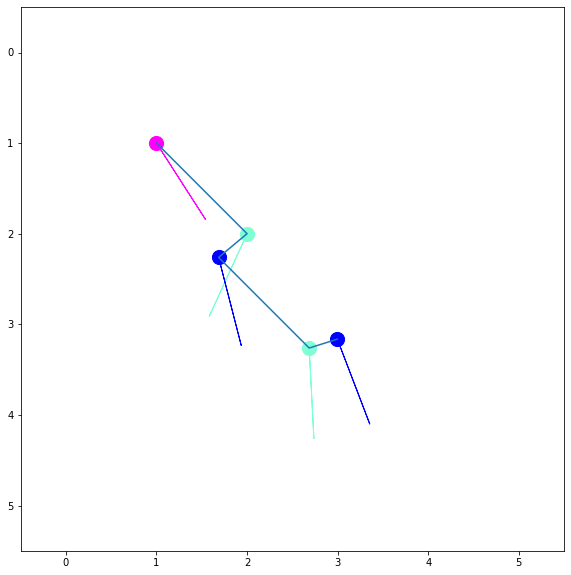

In [54]:
from KalmanFilterClass import KalmanFilterClass

#object declaration
kalmanFilter=KalmanFilterClass()

#initialisation
initialState=[1,1,1] #(x,y,théta)
kalmanFilter.setState(initialState)

#predicting
inputKalman=[1,1,1]
timeStep=1
predictedState=kalmanFilter.predict(inputKalman,timeStep)

#updating
measurement=[1.4,2.5,0.7]
updatedState=kalmanFilter.update(measurement)

#predicting 2
inputKalman=[1,1,0.2]
timeStep=1
predictedState2=kalmanFilter.predict(inputKalman,timeStep)

#updating 2
measurement=[3.2,3.1,1]
updatedState2=kalmanFilter.update(measurement)



#plotting
grid=np.zeros((6,6))
cmap = colors.ListedColormap(['white', 'grey'])
plt.figure(figsize=(10,10))
plt.imshow(grid, cmap=cmap)
plt.scatter(initialState[0], initialState[1], marker="o", color='magenta', s=200);
plt.arrow(initialState[0],initialState[1],math.cos(initialState[2]),math.sin(initialState[2]),ec='magenta')
plt.scatter(predictedState[0], predictedState[1], marker="o", color='aquamarine', s=200);
plt.arrow(predictedState[0],predictedState[1],math.cos(predictedState[2]),math.sin(predictedState[2]),ec='aquamarine')
plt.scatter(updatedState[0],updatedState[1], marker="o", color='blue', s=200);
plt.arrow(updatedState[0],updatedState[1], math.cos(updatedState[2]),math.sin(updatedState[2]),ec='blue')
plt.scatter(predictedState2[0], predictedState2[1], marker="o", color='aquamarine', s=200);
plt.arrow(predictedState2[0],predictedState2[1],math.cos(predictedState2[2]),math.sin(predictedState2[2]),ec='aquamarine')
plt.scatter(updatedState2[0],updatedState2[1], marker="o", color='blue', s=200);
plt.arrow(updatedState2[0],updatedState2[1], math.cos(updatedState2[2]),math.sin(updatedState2[2]),ec='blue')
_=plt.plot([initialState[0],predictedState[0],updatedState[0],predictedState2[0],updatedState2[0]],
         [initialState[1],predictedState[1],updatedState[1],predictedState2[1],updatedState2[1]])

### 5. Local Navigation <a class="anchor" id="chapter5"></a>
In the local navigation part, the goal is to control and run Thymio with given a given angle to follow, to avoid obstacles, and to recognize a kidnapping situation.  

#### 5.1 Local Avoidance <a class="anchor" id="section_5_1"></a>
Thymio has several useful sensors to detect obstacles such as proxy sensors. The idea of the local avoidance is to consider possible cases that Thymio meets. 

Local avoidance has two priority. If there is no obstacles, it uses the given angle correction to move. But if an obstacles is detected, then we forgot about following the path and we avoid the obstacles. When an obstacle is resolved, we get back to normal and follow again the given angle.

To avoid obstacles, we move (mainly we turn) until we can't detect the obstacles anymore, with a bit of safety margin. Then we always move forward. It turned out to be a successful way to avoid long obstacles. The problem was that Thymio have blind spot and can easily hit obstacles from the side. Turning then moving forward keep the distance to the obstacle great enough to never run into it. 

We follow the desired angle correction by setting two speed. the forward speed which is the common value given to the motors and rotational speed (omega) which is the differential value given to the motors. We start by defining a forward speed. It the desired angle correction is zero, then that's the speed we apply to the motors. But, if we have to correct , we decrease the forward speed by the amount of correction and we increase the rotationnal speed accordingly. This mean that the more we turn the lesse we move forward. This has great properties when it comes to avoid obstacles. Because, you move slower when you need to turn, you will detect obstacles before having them in your blind spot. Also, it reduces the overshoot when following the path , which is also desirable. 

Something we need to specify is the local navigation need to be called often enough in order to work. When call only once, it will simply set a motor speed and the robot will continue forever with those speed if we don't call the function again. Therefore to avoid obstacles and follow the path we update this function at a rate of arround 10 Hz.


**1. No obstacle**
```
if any obstacles are not detected within the threshold
    FOLLOW_GLOBAL_PATH with the given angle
end

function FOLLOW_GLOBAL_PATH
    INPUT    angle
    omega <- -angle
    motor_speed <- 180 - abs(3 * omega)
    limit motor_speed into range 0 to 200
    Go forward setting as follow:
        left  motor speed <- motor_speed - omega
        right motor speed <- motor_speed + omega
end
```

**2. Front obstacle**
```
if the front middle sensor value is greater than the threshold
    if Thymio is too close to the obstacle
        Go backward
    end

    if left_sensor_val - right_sensor_val < -100    # the obstacle is close to the left side
        Turn right
    if left_sensor_val - right_sensor_val > 100     # the obstacle is close to the right side
        Turn left
    else    # parallelly
        Turn left with probability 0.05
        Turn right with probability 0.95
    end
end

```

**3. Left/Right obstacle**
```
if any of two front left sensor values is greater than the threshold
    Turn right
end

if any of two front right sensor values is greater than the threshold
    Turn left
end
```
**4. Back obstacle**
```
if any of two back sensor values is greater than the threshold
    Go forward
end
```
**5. Deadlock**
```
if Thymio continues to alternate right and left turns over 20 times
    deadlock_flag <- TRUE
else
    deadlock_flag <- FALSE
end
if deadlock_flag is TRUE
    Turn right until there is no more obstacle
end
```

To make Thymio move smoothly, we set the motor speed corresponding to the distance to obstacles. Closer obstacles are, less motor speed is set. Local navigation return the forward speed and rotationnal speed (omega) applied to the motors so the kalman filter can use the odometry.


#### 5.2 Kidnapping <a class="anchor" id="section_5_2"></a>
The idea is to detect whether Thymio is kidnapped. For that, we check its proximity ground sensor (`prox.ground.reflected`) where the values correspond to the distance to the ground. Closer Thymio is to the ground, greater the sensor values are. It returns a flag wheter the thymio is kidnapped or not, so we can react accordingly.
```
if all of ground_sensor_val is less than threshold
    kidnap <- TRUE
else
    kidnap <- FALSE
end
```


 

### 6. Overall Project <a class="anchor" id="chapter6"></a>

Now, we have defined all functions we need to navigate our robot throughout the map. We can tackle the problem of making a general algortihm that uses every part.  


#### 6.1 Overview of the navigation algorithm <a class="anchor" id="section_6_1"></a>

**1. Variable Declaration**
```
- Import desired libraries and classes
- declare and initialize variables
- run the vision calibration to adapt filter to setup conditions
```


**2. Initialization**
```
- initialize the global map with robot, goal and obstacles positions
- compute the shorhest path and store it in globalMap
- intialize the kalman filter with the robot position

if something fail:
    re-start the initialization up to 10 times and quit if persistent failure
```

**3. Navigation Loop**
```
until the goal is not reached do :
    - predict next kalman state
    - take a new picture
    - detect the robot on this picture
    
    if detection is successful :
        - update kalman filter state with measurement
        
    - store kalman state as robot position and orientation in globalMap
    
    Check if the robot has reached the goal :
        - go to END
    
    - get the desired angle correction from motion planning
    - make the robot move with that desired correction
    
    Check if the robot has been kidnapp :
        - restart at initalization
        
     - wait 100 [mS] 
```

**4. End**
```
- stop the robot
- close the camera
```


The structures of the algorithm is pretty simple, thanks to the high level functions provided by our classes. Most of the complexity is therefore hidden. For example, there is nothing about avoiding an obstacles in the navigation algorithm. Everything is in fact manage in the local navigation. It will take care of resolving them on it's own without consequences on the main file. 

Also, in this algorithm we neglected the display part, which is of course intersting for us, but less relevant in for the navigation alogorithm. 

#### 6.2 Main Function <a class="anchor" id="section_6_2"></a>
In order to navigate the robot, one could simply run the main.py file. We don't do that here, in this jupyter notebook since it's not 100% compatible with it. To run everything properly, one should have a camera connected to his computer, and a thymio connected and turned on. Off course, a map and a goal is also needed. 

Nonetheless we also provide a fakemain.py file which simply fake the whole setup needed to run everything. A gaussian noise is added to the kalman prediction, which fakes the camera measurement. in green, you can see the "fake" camera measurement of the robot position and in blue you have the updated kalman filter state. 

### 7. Conclusion<a class="anchor" id="chapter7"></a>

    




### 8. Sources <a class="anchor" id="chapter8"></a>

We list here all the sources that were used for this project:

#### A* <a class="anchor" id="section_8_1"></a>
For the A* algorithm, we based ourself on the work from Andrew Jones who wrote an article on Analytics Link. His work is itself based on previous work from Christian Careaga. We made some little ajustement but the code is mostly from his work. It can be found at https://www.analytics-link.com/post/2018/09/14/applying-the-a-path-finding-algorithm-in-python-part-1-2d-square-grid .

#### Kalman Filter and Vision<a class="anchor" id="section_8_2"></a>
We used extensivly the work from L42project for our Kalman Filter and vision. He has a youtube channel with explanations of great quality and a gitHub repository where the code he uses can be found. We would like to thanks him specially for his help and ressources. We used his codes in our work.   It can be found at : 
youtube channel : https://www.youtube.com/channel/UCn09iU3hS5Fpxv0XniGv2FQ/about
GitHub repository : https://github.com/L42Project/Tutoriels


#### Computer Vision<a class="anchor" id="section_8_2"></a>

We use the tuto 4 from L42project to detect the different colors (red and green on our case) to separate thymio from the goal, see the link below:
https://github.com/L42Project/Tutoriels/blob/master/OpenCV/tutoriel4/detection_couleur_raspberry.py

In order to detect the circles for goal and thymio, we use this link:
https://www.pyimagesearch.com/2016/02/08/opencv-shape-detection/

In order to compute the area of the contour founded, we use the link below:
https://www.programcreek.com/python/example/86843/cv2.contourArea

This link was used to encircle the robot and the goal:
https://docs.opencv.org/3.4/dd/d49/tutorial_py_contour_features.html

For morphology transformations (erosion and dilatation) :
https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html

To draw circle on the robot and the goal, we use this link :
https://www.geeksforgeeks.org/python-opencv-cv2-circle-method/

For the rest of the functions, we use the functions from the exercise sessions in the Micro-452 course: 
https://moodle.epfl.ch/course/view.php?id=15293
